In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr 
import math
from pylab import *

#### Read in the TSV of data

In [104]:
df_total = pd.read_csv('test_player_dataframe_1.txt',sep='\t')

df_total.Salary = df_total['Salary'].str.replace('$','')
df_total.Salary = df_total['Salary'].str.replace(',','')

df_total.Salary = df_total['Salary'].astype(float)
#print(df_total.columns.values)
df_total.head()

,Unnamed: 0,Season,Age,Tm,Lg,Pos,G,GS,MP_x,FG,...,WS/48,OBPM,DBPM,BPM,VORP,Team,Salary,SalaryCap,Salary%,Player
0,0,1990-91,23,NJN,NBA,PF,74,68,35.2,6.9,...,0.108,-0.2,0.7,0.5,1.7,New Jersey Nets,2100000.0,"$11,871,000",0.17690,Derrick Coleman
1,1,1991-92,24,NJN,NBA,PF,65,58,34.0,7.4,...,0.121,1.2,0.7,1.9,2.2,New Jersey Nets,2300000.0,"$12,500,000",0.18400,Derrick Coleman
2,2,1992-93,25,NJN,NBA,PF,76,73,36.3,7.4,...,0.165,1.9,2.9,4.8,4.8,New Jersey Nets,2870000.0,"$14,000,000",0.20500,Derrick Coleman
3,3,1993-94,26,NJN,NBA,PF,77,77,36.1,7.0,...,0.171,2.4,2.1,4.5,4.5,New Jersey Nets,3440000.0,"$15,175,000",0.22669,Derrick Coleman
4,4,1994-95,27,NJN,NBA,PF,56,54,37.6,6.6,...,0.117,0.6,1.5,2.1,2.2,New Jersey Nets,4212000.0,"$15,964,000",0.26384,Derrick Coleman


#### Create two subsets of the "Advanced" and "Traditional" statistics

In [23]:
df_advanced = df_total[['WS','DWS','USG%','PER','TS%','DBPM','OBPM','BPM','VORP','Salary','Salary%','Player']]
df_traditional = df_total[['Age','GS','MP_x','FGA','PTS','TRB','AST','TOV','STL','BLK','Salary','Salary%']]

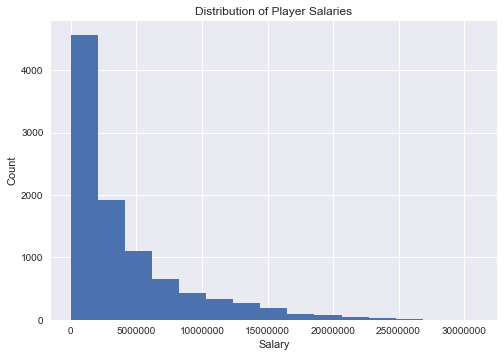

In [46]:
plt.hist(df_total['Salary'],bins=15)
plt.ticklabel_format(style='plain',axis='both')
plt.xlabel("Salary")
plt.ylabel("Count")
plt.title("Distribution of Player Salaries")
plt.show()

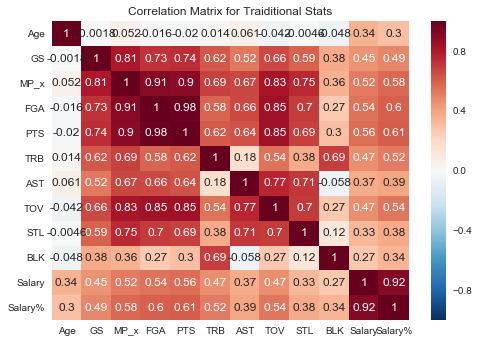

In [50]:
corr = df_traditional.corr()
heat_map = sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True)
plt.title("Correlation Matrix for Traiditional Stats")
plt.show()

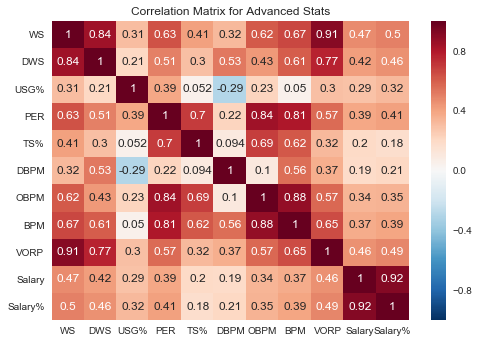

In [51]:
corr = df_advanced.corr()
heat_map = sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True)
plt.title("Correlation Matrix for Advanced Stats")
plt.show()

#### One take away from the above correlation matrices, is that we getter better correlation numbers across the board when comparing to Salary% (the salary as a percentage of the salary cap for that year) rather than just straight Salary.  Many of these stats are closely related, like FGA and Points, so we'll want to select a set of variables that are conveying different information about the player.

Create a dataframe that represents the weighted averages of each player's seasons on their rookie contract.  This will give us a representation of their body of work up until the point of their new contract.  Store the player's new non-rookie contract in the same row so we can see the relationships between the weighted averages of statistics and their new contract.

In [52]:
players = df_total['Player'].unique()

list_of_rookie_contract_data = []
list_of_first_contract_data = []
list_of_columns_to_average = ['Age','G','GS','MP_x','FG','FGA',
 'FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB',
 'DRB','TRB','AST','STL','BLK','TOV','PF','PTS','MP_y','PER','TS%','3PAr',
 'FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS',
 'WS','WS/48','OBPM','DBPM','BPM','VORP']
list_of_averaged_rows = []

#For each player in original dataset, create a Rookie table of just his first 4 seasons
#Also create a Contract datatable of his first year with the new contract
for player in players:
    df_player = df_total[df_total['Player'] == player]
    df_player_rookie = df_player.iloc[0:3]
    df_player_contract = df_player.iloc[4:5]
#Append these individual dataframes to separate lists, they will later be concatendated into one larger dataframe    
    list_of_rookie_contract_data.append(df_player_rookie)
    list_of_first_contract_data.append(df_player_contract)

#############################################################################################
# Create a dataframe of the weight averages of numerical columns during players first 4 seasons
#############################################################################################    
    weight_array =[]
    total_minutes = 0
    for index, row in df_player_rookie.iterrows():
        #The weight used will be based off minutes played for each seasons
        weight = row.MP_x * row.G
        #Make an array of the weights for each season
        weight_array.append(weight)
        total_minutes = weight + total_minutes
    #If they didn't play in a given season, skip    
    if total_minutes == 0:
        continue
    #Normalize the weight array    
    weight_array[:] = [x / total_minutes for x in weight_array]

    ##Iterate through the new Rookie dataframe, apply weighted average for numerical columns
    ##If column is Salary, grab it from the Contract table
    ##If column is non-numeric, just add a placeholder value to the row
    new_row = []
    if len(df_player) <5:
        continue
    for column in df_player_rookie.columns:        
        if column in list_of_columns_to_average:
            new_row.append(np.dot(weight_array,df_player_rookie[column]))
        elif column == 'Salary':
            new_row.append(df_player.iloc[4:5]['Salary'].values[0])
        elif column == 'Salary%':
            new_row.append(df_player.iloc[4:5]['Salary%'].values[0])    
        else:
            var = df_player_rookie.iloc[:-2][column].values[0]
            new_row.append(var)
    list_of_averaged_rows.append(new_row)
list_of_averaged_rows = pd.Series(list_of_averaged_rows)

##Make the larger rookie and contract dataframes
df_rookie_total = pd.concat(list_of_rookie_contract_data)
df_contract_total = pd.concat(list_of_first_contract_data)
##Make the larger rookie_averages dataframe
df_rookie_averages = pd.DataFrame.from_items(zip(list_of_averaged_rows.index,list_of_averaged_rows.values)).T
df_rookie_averages.columns = list(df_total.columns.values)

#### The following section will investigate and display the relationships between various variables and the Salary% field.  From here we can begin to get an idea of what variables might be important to use in a model. 

Points and Salary Correlation
(0.73160367058835285, 2.9885544209856864e-129)


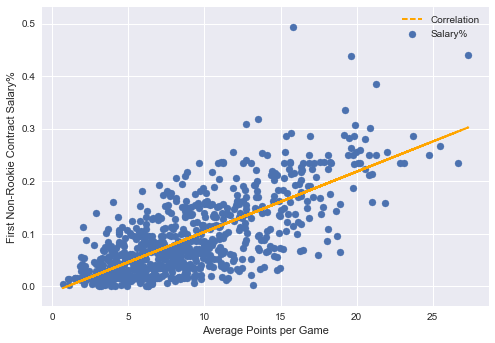

In [70]:
plt.scatter(df_rookie_averages['PTS'],df_rookie_averages['Salary%'])
plt.xlabel('Average Points per Game')
plt.ylabel('First Non-Rookie Contract Salary%')

np_x = np.float32(np.asarray(df_rookie_averages['PTS']))
np_y = np.asarray(df_rookie_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend()

print('Points and Salary Correlation')
print(pearsonr(df_rookie_averages['PTS'],df_rookie_averages['Salary%']))

plt.show()

Assists and Salary Correlation
(0.4019469965239279, 4.1611516091925673e-31)


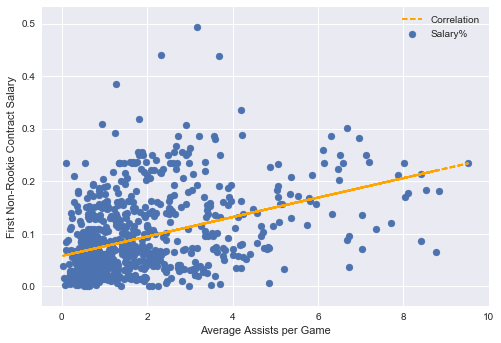

In [71]:
plt.scatter(df_rookie_averages['AST'],df_rookie_averages['Salary%'])
plt.xlabel('Average Assists per Game')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(df_rookie_averages['AST']))
np_y = np.asarray(df_rookie_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend()

print('Assists and Salary Correlation')
print(pearsonr(df_rookie_averages['AST'],df_rookie_averages['Salary%']))

plt.show()

Total Rebounds and Salary Correlation
(0.61473780120964328, 8.4051613679495345e-81)


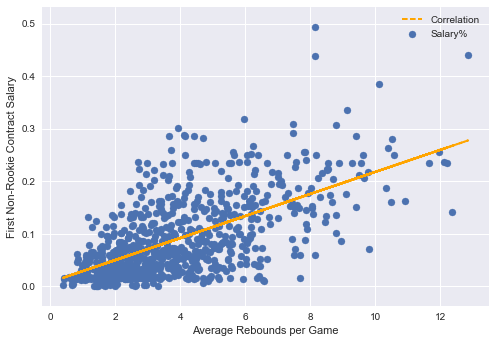

In [79]:
plt.scatter(df_rookie_averages['TRB'],df_rookie_averages['Salary%'])
plt.xlabel('Average Rebounds per Game')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(df_rookie_averages['TRB']))
np_y = np.asarray(df_rookie_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend()

print('Total Rebounds and Salary Correlation')
print(pearsonr(df_rookie_averages['TRB'],df_rookie_averages['Salary%']))

plt.show()

Steals and Salary Correlation
(0.48295022529514425, 5.1786302929510269e-46)


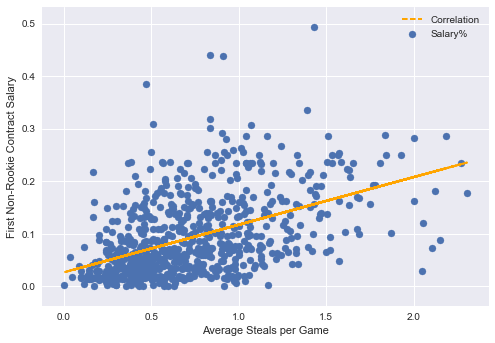

In [80]:
plt.scatter(df_rookie_averages['STL'],df_rookie_averages['Salary%'])
plt.xlabel('Average Steals per Game')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(df_rookie_averages['STL']))
np_y = np.asarray(df_rookie_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend()

print('Steals and Salary Correlation')
print(pearsonr(df_rookie_averages['STL'],df_rookie_averages['Salary%']))

plt.show()

VORP and Salary Correlation
(0.68732862716278376, 3.4386958261694106e-108)


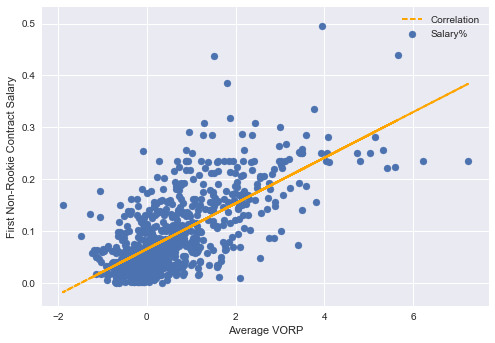

In [74]:
plt.scatter(df_rookie_averages['VORP'],df_rookie_averages['Salary%'])
plt.xlabel('Average VORP')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(df_rookie_averages['VORP']))
np_y = np.asarray(df_rookie_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend()

print('VORP and Salary Correlation')
print(pearsonr(df_rookie_averages['VORP'],df_rookie_averages['Salary%']))

plt.show()

Shooting Effectiveness and Salary Correlation
(0.70698297165652291, 4.7304151991195752e-117)


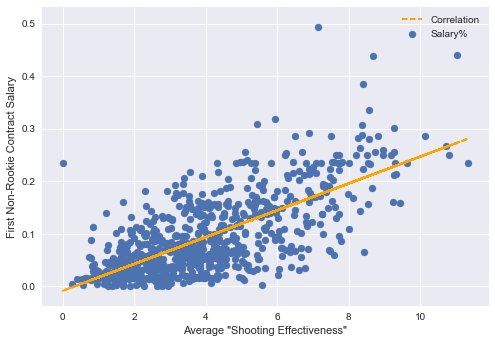

In [78]:
shooting_effectiveness = df_rookie_averages['FGA'] * df_rookie_averages['TS%']

for index,val in shooting_effectiveness.iteritems():
    if math.isnan(val):
        shooting_effectiveness[index]=0
        
plt.scatter(shooting_effectiveness,df_rookie_averages['Salary%'])
plt.xlabel('Average "Shooting Effectiveness"')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(shooting_effectiveness))
np_y = np.asarray(df_rookie_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth =2,label = 'Correlation')
plt.legend()

print('Shooting Effectiveness and Salary Correlation')
print(pearsonr(df_rookie_averages['Salary%'],shooting_effectiveness))

plt.show()

#### Unsurprisingly, we see that Points and Shooting Effectiveness correlate with Salary% the most.  Assists and Steals don't have as strong of correlation levels.  It could be interesting to investigate how these variables differ by position.  Perhaps Assists and Steals matter, but only for PGs?  Perhaps Rebounds and Blocks are only important for Forwards and Centers?
#### It would also be interesting to see if these correlation levels vary during different eras.  Our data spans over 20 years, and trends in the NBA hae risen and fallen in that time.  Perhaps Shooting Effectiveness is a better predictor of Salary in more recent years during the era of analytics?

In [91]:
df_big_men_averages = df_rookie_averages[(df_rookie_averages.Pos == 'PF')|(df_rookie_averages.Pos == 'C')]
df_wings_averages = df_rookie_averages[(df_rookie_averages.Pos == 'SF')|(df_rookie_averages.Pos == 'SG')]
df_pointguard_averages = df_rookie_averages[(df_rookie_averages.Pos == 'PG')]

Assists and Salary Correlation: Point Guards
(0.70121230386318767, 1.6605531954312331e-23)
Assists and Salary Correlation: Big Men
(0.60042199959738585, 1.6424983841997414e-33)
Assists and Salary Correlation: Wings
(0.54699077525995932, 1.0183302401858357e-23)


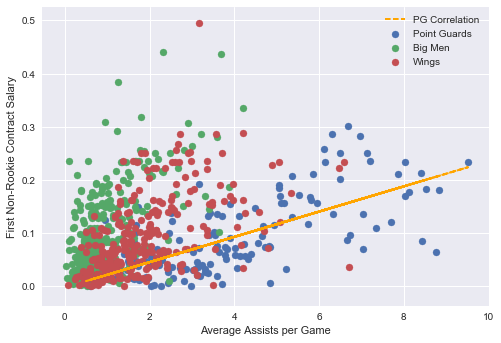

In [98]:
plt.scatter(df_pointguard_averages['AST'],df_pointguard_averages['Salary%'])
plt.scatter(df_big_men_averages['AST'],df_big_men_averages['Salary%'])
plt.scatter(df_wings_averages['AST'],df_wings_averages['Salary%'])

plt.xlabel('Average Assists per Game')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(df_pointguard_averages['AST']))
np_y = np.asarray(df_pointguard_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend(('PG Correlation','Point Guards','Big Men','Wings'))

print('Assists and Salary Correlation: Point Guards')
print(pearsonr(df_pointguard_averages['AST'],df_pointguard_averages['Salary%']))

print('Assists and Salary Correlation: Big Men')
print(pearsonr(df_big_men_averages['AST'],df_big_men_averages['Salary%']))

print('Assists and Salary Correlation: Wings')
print(pearsonr(df_wings_averages['AST'],df_wings_averages['Salary%']))

plt.show()

Rebounds and Salary Correlation: Point Guards
(0.7552576397147569, 6.0468262258262189e-29)
Rebounds and Salary Correlation: Big Men
(0.74163121712589353, 1.7567932919672647e-58)
Rebounds and Salary Correlation: Wings
(0.63089881094076894, 3.7321671759742483e-33)


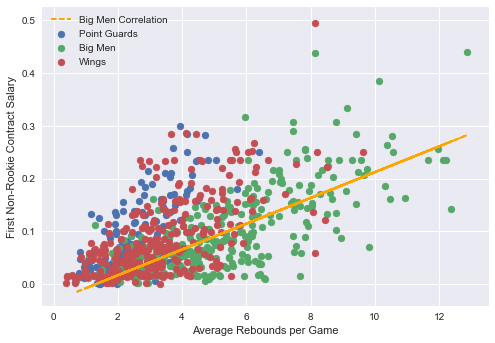

In [101]:
plt.scatter(df_pointguard_averages['TRB'],df_pointguard_averages['Salary%'])
plt.scatter(df_big_men_averages['TRB'],df_big_men_averages['Salary%'])
plt.scatter(df_wings_averages['TRB'],df_wings_averages['Salary%'])

plt.xlabel('Average Rebounds per Game')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(df_big_men_averages['TRB']))
np_y = np.asarray(df_big_men_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend(('Big Men Correlation','Point Guards','Big Men','Wings'))

print('Rebounds and Salary Correlation: Point Guards')
print(pearsonr(df_pointguard_averages['TRB'],df_pointguard_averages['Salary%']))

print('Rebounds and Salary Correlation: Big Men')
print(pearsonr(df_big_men_averages['TRB'],df_big_men_averages['Salary%']))

print('Rebounds and Salary Correlation: Wings')
print(pearsonr(df_wings_averages['TRB'],df_wings_averages['Salary%']))

plt.show()

Rebounds and Salary Correlation: Point Guards
(0.55019455867264466, 3.0306297661376124e-13)
Rebounds and Salary Correlation: Big Men
(0.52423652110718078, 1.4939256865414979e-24)
Rebounds and Salary Correlation: Wings
(0.4699292143078474, 4.0659727038079524e-17)


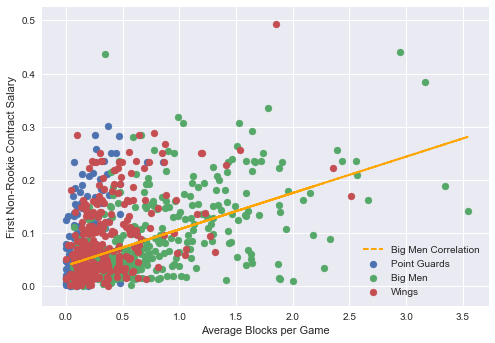

In [103]:
plt.scatter(df_pointguard_averages['BLK'],df_pointguard_averages['Salary%'])
plt.scatter(df_big_men_averages['BLK'],df_big_men_averages['Salary%'])
plt.scatter(df_wings_averages['BLK'],df_wings_averages['Salary%'])

plt.xlabel('Average Blocks per Game')
plt.ylabel('First Non-Rookie Contract Salary')

np_x = np.float32(np.asarray(df_big_men_averages['BLK']))
np_y = np.asarray(df_big_men_averages['Salary%'])

m,b = np.polyfit(np_x,np_y,1)
plt.plot(np_x,m*np_x+b,'-', color='orange',linestyle = 'dashed',linewidth = 2,label = 'Correlation')
plt.legend(('Big Men Correlation','Point Guards','Big Men','Wings'))

print('Rebounds and Salary Correlation: Point Guards')
print(pearsonr(df_pointguard_averages['BLK'],df_pointguard_averages['Salary%']))

print('Rebounds and Salary Correlation: Big Men')
print(pearsonr(df_big_men_averages['BLK'],df_big_men_averages['Salary%']))

print('Rebounds and Salary Correlation: Wings')
print(pearsonr(df_wings_averages['BLK'],df_wings_averages['Salary%']))

plt.show()

#### Unsurprisingly, we see that Assists are much more correlated with Salary% when we isolate Point Guards from the larger population.  Somewaht surprisingly, Rebounds and Blocks aren't appreciably better correlated with Salary for Big Men than they are for Point Guards.

## Inferential Statistics

#### Perform hypothesis tests on the correlation levels for the positional subsets for certain statistics

In [128]:
def Calc_Correlation_Significance(df_position, column):
    import scipy.stats as stats

    pop_corr = pearsonr(df_rookie_averages[column],df_rookie_averages['Salary%'])
    sample_corr = pearsonr(df_position[column],df_position['Salary%'])
    n = len(df_position)

    t_stat = (sample_corr[0] - pop_corr[0])/(np.std(df_rookie_averages[column])/np.sqrt(n))
    pval = stats.t.sf(np.abs(t_stat), n-1)*1

    print("Correlation Level:",sample_corr)
    print("T-Statistic:",t_stat)
    print("P-value:",pval)

In [129]:
print("Hypothesis Test for Point Guard Assists Correlation to Salary%")
Calc_Correlation_Significance(df_pointguard_averages,'AST')

Hypothesis Test for Point Guard Assists Correlation to Salary%
Correlation Level: (0.70121230386318767, 1.6605531954312331e-23)
T-Statistic: 2.22992901245
P-value: 0.0136236854668


In [130]:
print("Hypothesis Test for Big Men Rebounds Correlation to Salary%")
Calc_Correlation_Significance(df_big_men_averages,'TRB')

Hypothesis Test for Big Men Rebounds Correlation to Salary%
Correlation Level: (0.74163121712589353, 1.7567932919672647e-58)
T-Statistic: 1.03416006754
P-value: 0.150912769553


In [131]:
print("Hypothesis Test for Big Men Blocks Correlation to Salary%")
Calc_Correlation_Significance(df_big_men_averages,'BLK')

Hypothesis Test for Big Men Blocks Correlation to Salary%
Correlation Level: (0.52423652110718078, 1.4939256865414979e-24)
T-Statistic: 3.40819772578
P-value: 0.000367839472286


In [132]:
print("Hypothesis Test for Point Guard Steals Correlation to Salary%")
Calc_Correlation_Significance(df_pointguard_averages,'STL')

Hypothesis Test for Point Guard Steals Correlation to Salary%
Correlation Level: (0.69133805277996574, 1.2136048898076251e-22)
T-Statistic: 6.31829349257
P-value: 1.44713193237e-09


In [137]:
print("Hypothesis Test for Big Men 3PT Correlation to Salary%")
Calc_Correlation_Significance(df_big_men_averages,'3P')

Hypothesis Test for Big Men 3PT Correlation to Salary%
Correlation Level: (0.063411314505343597, 0.25212785973728141)
T-Statistic: -3.76092731862
P-value: 0.000100264441659


In [140]:
print("Hypothesis Test for Point Guard 3PT Correlation to Salary%")
Calc_Correlation_Significance(df_pointguard_averages,'PTS')

Hypothesis Test for Point Guard 3PT Correlation to Salary%
Correlation Level: (0.77302361404142261, 4.7140980834195936e-31)
T-Statistic: 0.105000002556
P-value: 0.458258510823
